# Spatial Models - Networks

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend

%matplotlib inline
plt.style.use('default')

no display found. Using non-interactive Agg backend


In [2]:
# Import the csv file
df = pd.read_csv('transmission_network.csv', sep=';')
df = df.rename(columns={df.columns[0]:'nodes'})

In [3]:
# Create graph object and add nodes to it
Graph_obj = nx.Graph()
nodes = df['nodes'].tolist()
Graph_obj.add_nodes_from(nodes)

In [4]:
print(len(nodes))

374


In [5]:
# Add edges between nodes based on the csv-file
for _, row in df.iterrows():
    source_node = row['nodes']
    for col_name, edge_value in row.items():
        if col_name != 'nodes' and edge_value != 0:
            Graph_obj.add_edge(source_node, int(col_name))

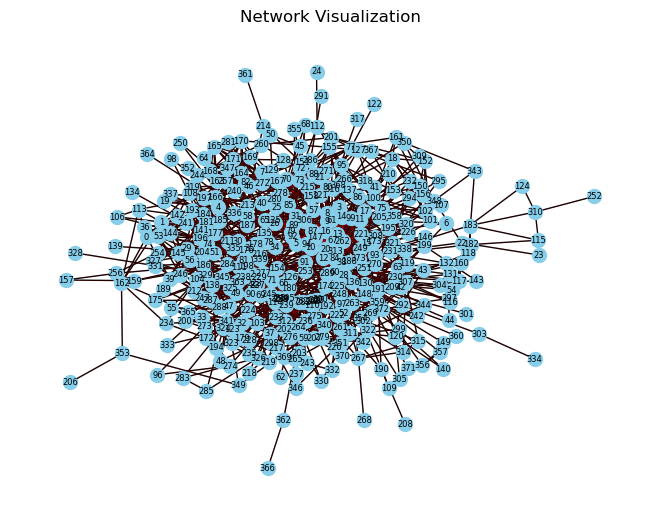

In [6]:
# Relabel the nodes
Graph_obj = nx.convert_node_labels_to_integers(Graph_obj, first_label=0)

# create a layout for the nodes
pos = nx.kamada_kawai_layout(Graph_obj)

# draw the nodes and edges
nx.draw(Graph_obj, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_color='black')
nx.draw_networkx_edges(Graph_obj, pos, edge_color='red', width=0.1)

# display the graph
plt.axis('off')
plt.title("Network Visualization")
plt.show()

In [7]:
# Generate SIR model object
SIR_model = ep.SIRModel(Graph_obj)

# Set parameter values
betas = np.linspace(0.1, 3, 101)
gammas = np.linspace(0.01, 1, 101)
percentage_infected = 0.01
nr_iterations = 200

# Pre-allocate variables.
S_store = np.zeros((len(betas), len(gammas), nr_iterations))
I_store = np.zeros((len(betas), len(gammas), nr_iterations))
R_store = np.zeros((len(betas), len(gammas), nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)

for beta_ix, beta in enumerate(betas):
    for gamma_ix, gamma in enumerate(gammas):
        # (Re)set every node as susceptible
        for node in Graph_obj.nodes():
            SIR_model.status[node] = 0
            
        # Set model configurations
        cfg.add_model_parameter('beta', beta)
        cfg.add_model_parameter('gamma', gamma)
        SIR_model.set_initial_status(cfg)
        iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
        trends = SIR_model.build_trends(iterations)
        
        # Extract values based on updated structure
        node_counts = trends[0]['trends']['node_count']
        S = node_counts[0]
        I = node_counts[1]
        R = node_counts[2]

        # Store the sums for averages
        S_store[beta_ix, gamma_ix] = S
        I_store[beta_ix, gamma_ix] = I
        R_store[beta_ix, gamma_ix] = R

In [8]:
beta_index = 5
Gamma_index = 5

S_mean_0 = np.mean(S_store[beta_index], axis=0)
I_mean_0 = np.mean(I_store[beta_index], axis=0)
R_mean_0 = np.mean(R_store[beta_index], axis=0)
S_std_0 = np.std(S_store[beta_index], axis=0)
I_std_0 = np.std(I_store[beta_index], axis=0)
R_std_0 = np.std(R_store[beta_index], axis=0)

S_mean_1 = np.mean(S_store[:, Gamma_index], axis=0)
I_mean_1 = np.mean(I_store[:, Gamma_index], axis=0)
R_mean_1 = np.mean(R_store[:, Gamma_index], axis=0)
S_std_1 = np.std(S_store[:, Gamma_index], axis=0)
I_std_1 = np.std(I_store[:, Gamma_index], axis=0)
R_std_1 = np.std(R_store[:, Gamma_index], axis=0)

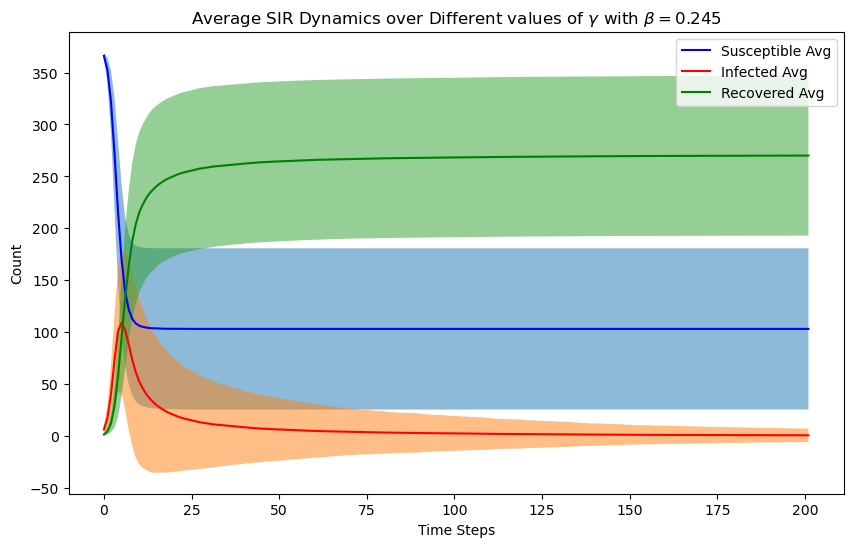

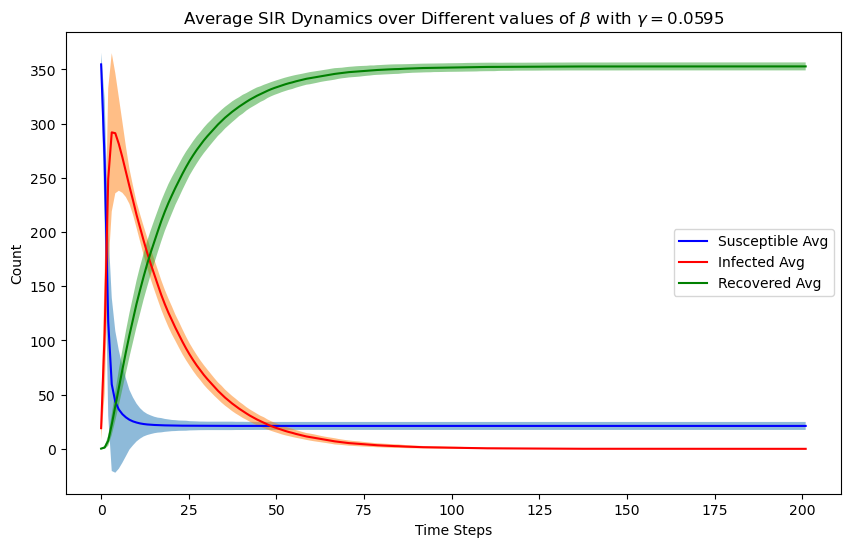

In [9]:
x = np.linspace(0, 201, 200)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S_mean_0, label="Susceptible Avg", color='blue')
plt.fill_between(x, S_mean_0 - S_std_0,S_mean_0 + S_std_0, alpha=0.5) 
plt.plot(x, I_mean_0, label="Infected Avg", color='red')
plt.fill_between(x, I_mean_0 - I_std_0,I_mean_0 + I_std_0, alpha=0.5) 
plt.plot(x, R_mean_0, label="Recovered Avg", color='green')
plt.fill_between(x, R_mean_0 - R_std_0,R_mean_0 + R_std_0, alpha=0.5) 
plt.title(fr"Average SIR Dynamics over Different values of $\gamma$ with $\beta = {betas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S_mean_1, label="Susceptible Avg", color='blue')
plt.fill_between(x, S_mean_1 - S_std_1,S_mean_1 + S_std_1, alpha=0.5) 
plt.plot(x, I_mean_1, label="Infected Avg", color='red')
plt.fill_between(x, I_mean_1 - I_std_1,I_mean_1 + I_std_1, alpha=0.5) 
plt.plot(x, R_mean_1, label="Recovered Avg", color='green')
plt.fill_between(x, R_mean_1 - R_std_1,R_mean_1 + R_std_1, alpha=0.5) 
plt.title(fr"Average SIR Dynamics over Different values of $\beta$ with $\gamma = {gammas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()

## Similar networks

In [16]:
def statistic_func(Graph):
    # Pre-allocating return variable
    stats = {}
    
    stats['Nr_of_nodes'] = Graph.number_of_nodes()
    stats['Nr_of_edges'] = Graph.number_of_edges()
        

    degrees = [degree for degree in Graph.degree()]
    stats['Average_degree'] = np.mean(degrees)
    
    
    if degrees:
        stats['average_clustering_coefficient'] = nx.average_clustering(Graph)
        stats['density'] = nx.density(Graph)
        
        degree_centralities = nx.degree_centrality(Graph)
        stats['average_degree_centrality'] = np.mean(list(degree_centralities.values()))
        
        betweenness_centralities = nx.betweenness_centrality(Graph)
        stats['average_betweenness_centrality'] = np.mean(list(betweenness_centralities.values()))
        
        closeness_centrality = nx.closeness_centrality(Graph)
        stats['average_closeness_centrality'] = np.mean(list(closeness_centrality.values()))
        
        if nx.is_connected(Graph):
            stats['diameter'] = nx.diameter(Graph)
            stats['average_shortest_path_length'] = nx.average_shortest_path_length(Graph)
            
        else:
            stats['diameter'] = None
            stats['average_shortest_path_length'] = None
    else:
        stats['average_clustering_coefficient'] = None
        stats['density'] = None
        stats['average_degree_centrality'] = None
        stats['average_betweenness_centrality'] = None
        stats['average_closeness_centrality'] = None

    return stats

### Erdös-Rénji Network


In [17]:
network_size = np.arange(50, 550, 50)
connection_probability = np.arange(0.05, 1.05, 0.05)

results_ER = []

for size in network_size:
    for p in connection_probability:
        Graph_ER = nx.erdos_renyi_graph(size, p)
        stats_ER = statistic_func(Graph_ER)
        results_ER.append(stats_ER)

df_ER = pd.DataFrame(results_ER)

In [19]:
custom_summary = df_ER.groupby(df_ER.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)

Nr_of_edges                                                     \
                   mean           std   median   min     max           var   
Nr_of_nodes                                                                  
50               644.25    364.667531    648.0    63    1225  1.329824e+05   
100             2590.00   1460.616633   2577.0   248    4950  2.133401e+06   
150             5877.35   3287.297695   5857.5   566   11175  1.080633e+07   
200            10451.10   5905.035406  10431.5   932   19900  3.486944e+07   
250            16327.55   9196.336516  16270.5  1545   31125  8.457261e+07   
300            23545.60  13295.417293  23409.0  2271   44850  1.767681e+08   
350            32075.65  18067.241872  32121.0  2969   61075  3.264252e+08   
400            41892.75  23611.552447  41966.0  4010   79800  5.575054e+08   
450            53066.25  29888.542117  52958.5  5039  101025  8.933249e+08   
500            65464.70  36902.712608  65293.0  6309  124750  1.361810e+09   

            Average_degree                                     ... diameter  \
                      mean        std      median         min  ...   median   
Nr_of_nodes                                                    ...            
50               25.135000   7.293351   25.210000   13.510000  ...      2.0   
100              50.650000  14.606166   50.520000   27.230000  ...      2.0   
150              76.432333  21.915318   76.300000   41.023333  ...      2.0   
200             102.005500  29.525177  101.907500   54.410000  ...      2.0   
250             127.560200  36.785346  127.332000   68.430000  ...      2.0   
300             153.235333  44.318058  152.780000   82.320000  ...      2.0   
350             178.894714  51.620691  179.024286   95.732857  ...      2.0   
400             204.481875  59.028881  204.665000  109.775000  ...      2.0   
450             230.175000  66.418982  229.935556  123.447778  ...      2.0   
500             255.679400  73.805425  255.336000  137.368000  ...      2.0   

                                average_shortest_path_length            \
             min  max       var                         mean       std   
Nr_of_nodes                                                              
50           1.0  5.0  0.812865                     1.512266  0.416906   
100          1.0  6.0  1.102632                     1.548818  0.458847   
150          1.0  6.0  0.976316                     1.520734  0.400901   
200          1.0  4.0  0.378947                     1.514859  0.386616   
250          1.0  4.0  0.378947                     1.505280  0.360956   
300          1.0  4.0  0.344737                     1.498952  0.348118   
350          1.0  4.0  0.344737                     1.497220  0.344416   
400          1.0  4.0  0.344737                     1.493155  0.334019   
450          1.0  3.0  0.200000                     1.490781  0.329258   
500          1.0  3.0  0.155263                     1.488841  0.323391   

                                                
               median  min       max       var  
Nr_of_nodes                                     
50           1.436735  1.0  2.706939  0.173810  
100          1.479394  1.0  2.965859  0.210540  
150          1.475839  1.0  2.699508  0.160722  
200          1.475804  1.0  2.609146  0.149472  
250          1.477253  1.0  2.469751  0.130290  
300          1.478060  1.0  2.388406  0.121186  
350          1.474073  1.0  2.371216  0.118623  
400          1.474110  1.0  2.296353  0.111569  
450          1.475788  1.0  2.262153  0.108411  
500          1.476609  1.0  2.215174  0.104582  

[10 rows x 54 columns]

In [33]:
ps = np.arange(0.018, 0.02, 0.001)
for p in ps:
    Graph_ER = nx.erdos_renyi_graph(374, p)
    stats_ER = statistic_func(Graph_ER)
    print(p, stats_ER['Nr_of_edges'])

0.018 1281
0.019 1300
0.02 1394


In [35]:
# Generate Barabasi-Albert graph similar to the given model
Graph_ER = nx.erdos_renyi_graph(374, 0.019)

# Generate SIR model object
SIR_model = ep.SIRModel(Graph_ER)

# Set parameter values
beta = 1.5
gamma = 0.3
percentage_infected = 5/374
nr_iterations = 200

# Pre-allocate variables.
S_store = np.zeros((nr_iterations))
I_store = np.zeros((nr_iterations))
R_store = np.zeros((nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)


# Set every node as susceptible
for node in Graph_obj.nodes():
    SIR_model.status[node] = 0
    
# Set model configurations
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
SIR_model.set_initial_status(cfg)
iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
trends = SIR_model.build_trends(iterations)

# Extract values based on updated structure
node_counts = trends[0]['trends']['node_count']
S = node_counts[0]
I = node_counts[1]
R = node_counts[2]

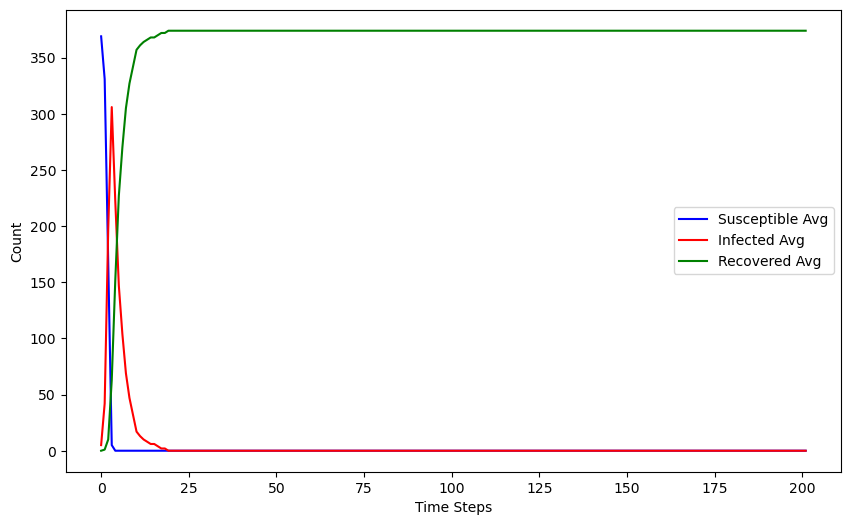

In [38]:
x = np.linspace(0, 201, 200)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S, label="Susceptible Avg", color='blue')
plt.plot(x, I, label="Infected Avg", color='red')
plt.plot(x, R, label="Recovered Avg", color='green')
# plt.title(fr"Average SIR Dynamics over Different values of $\gamma$ with $\beta = {betas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()


## Watts-Stograz network

In [20]:
nodes = np.arange(50, 550, 50) 
k_values = np.arange(1,10,1)
p_values = np.linspace(0.1, 1, 10)

results_WS = []

for size in nodes:
    for k in k_values:
        for p in p_values:
            Graph_WS = nx.watts_strogatz_graph(size, k, p)
            stats_WR = statistic_func(Graph_WS)
            results_WS.append(stats_WR)
            
df_WS = pd.DataFrame(results_WS)

c:\Users\kevin\anaconda3\envs\ABM\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\kevin\anaconda3\envs\ABM\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [21]:
custom_summary = df_WS.groupby(df_WS.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)

Nr_of_edges                                                \
                   mean         std  median  min   max            var   
Nr_of_nodes                                                             
0                   0.0    0.000000     0.0    0     0       0.000000   
50                125.0   56.254395   125.0   50   200    3164.556962   
100               250.0  112.508790   250.0  100   400   12658.227848   
150               375.0  168.763185   375.0  150   600   28481.012658   
200               500.0  225.017580   500.0  200   800   50632.911392   
250               625.0  281.271975   625.0  250  1000   79113.924051   
300               750.0  337.526370   750.0  300  1200  113924.050633   
350               875.0  393.780765   875.0  350  1400  155063.291139   
400              1000.0  450.035160  1000.0  400  1600  202531.645570   
450              1125.0  506.289555  1125.0  450  1800  256329.113924   
500              1250.0  562.543950  1250.0  500  2000  316455.696203   

            Average_degree                            ... diameter       \
                      mean       std  median     min  ...   median  min   
Nr_of_nodes                                           ...                 
0                      NaN       NaN     NaN     NaN  ...      NaN  NaN   
50                   14.75  1.125088   14.75   13.25  ...      5.0  3.0   
100                  27.25  1.125088   27.25   25.75  ...      5.0  4.0   
150                  39.75  1.125088   39.75   38.25  ...      6.0  4.0   
200                  52.25  1.125088   52.25   50.75  ...      6.0  4.0   
250                  64.75  1.125088   64.75   63.25  ...      6.0  4.0   
300                  77.25  1.125088   77.25   75.75  ...      7.0  5.0   
350                  89.75  1.125088   89.75   88.25  ...      7.0  5.0   
400                 102.25  1.125088  102.25  100.75  ...      7.0  5.0   
450                 114.75  1.125088  114.75  113.25  ...      7.0  5.0   
500                 127.25  1.125088  127.25  125.75  ...      7.0  5.0   

                               average_shortest_path_length            \
               max         var                         mean       std   
Nr_of_nodes                                                             
0              NaN         NaN                          NaN       NaN   
50            37.0   43.764476                     3.462732  2.255424   
100           49.0   85.168349                     4.143342  3.103891   
150           72.0  111.133929                     4.255405  3.831968   
200           57.0  135.280288                     4.773689  4.227088   
250           66.0  209.107644                     5.472674  5.147794   
300           70.0  362.221325                     6.599219  6.748005   
350           98.0  455.748082                     6.862091  7.637971   
400           97.0  366.198553                     6.421303  7.101184   
450           79.0  171.516129                     5.218322  4.670706   
500          100.0  413.531250                     6.305228  7.265845   

                                                       
               median       min        max        var  
Nr_of_nodes                                            
0                 NaN       NaN        NaN        NaN  
50           2.495102  2.038367  13.408163   5.086936  
100          2.965859  2.391717  16.169293   9.634139  
150          3.190380  2.604474  27.756152  14.683978  
200          3.462714  2.751156  23.466432  17.868271  
250          3.649157  2.860851  24.519550  26.499783  
300          4.054259  2.958016  26.739376  45.535569  
350          4.067933  3.035137  35.449726  58.338601  
400          4.005977  3.109662  38.434724  50.426819  
450          3.920356  3.168503  27.415293  21.815497  
500          4.121555  3.223094  40.115303  52.792501  

[11 rows x 54 columns]

In [22]:
display(df_WS)

,Nr_of_nodes,Nr_of_edges,Average_degree,average_clustering_coefficient,density,average_degree_centrality,average_betweenness_centrality,average_closeness_centrality,diameter,average_shortest_path_length
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
895,500,2000,128.75,0.049375,0.016032,0.016032,0.004566,0.305844,5.0,3.273756
896,500,2000,128.75,0.029596,0.016032,0.016032,0.004515,0.308249,5.0,3.248713
897,500,2000,128.75,0.017065,0.016032,0.016032,0.004476,0.310179,5.0,3.228858
898,500,2000,128.75,0.014385,0.016032,0.016032,0.004476,0.310178,5.0,3.229186


In [48]:
# Generate Barabasi-Albert graph similar to the given model
Graph_WS = nx.watts_strogatz_graph(374, 4, 0.9)

# Generate SIR model object
SIR_model = ep.SIRModel(Graph_WS)

# Set parameter values
beta = 1.5
gamma = 0.3
percentage_infected = 5/374
nr_iterations = 100

# Pre-allocate variables.
S_store = np.zeros((nr_iterations))
I_store = np.zeros((nr_iterations))
R_store = np.zeros((nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)


# Set every node as susceptible
for node in Graph_obj.nodes():
    SIR_model.status[node] = 0
    
# Set model configurations
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
SIR_model.set_initial_status(cfg)
iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
trends = SIR_model.build_trends(iterations)

# Extract values based on updated structure
node_counts = trends[0]['trends']['node_count']
S = node_counts[0]
I = node_counts[1]
R = node_counts[2]

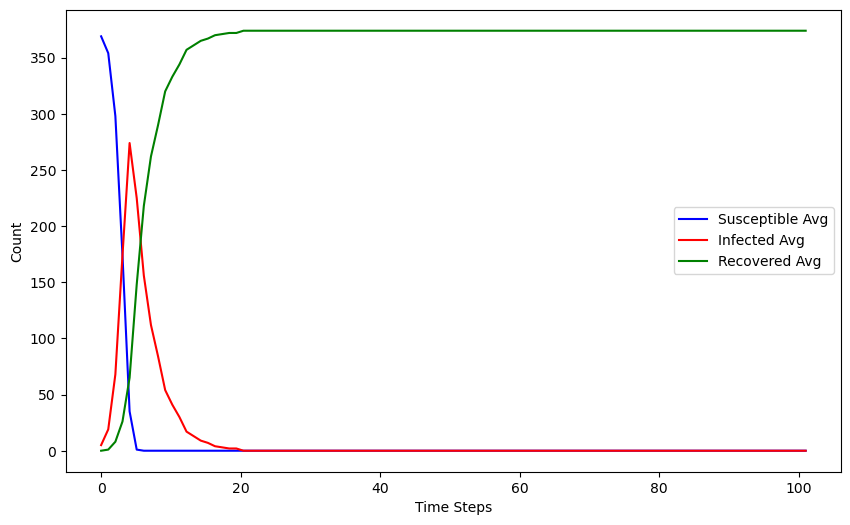

In [49]:
x = np.linspace(0, nr_iterations+1, nr_iterations)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S, label="Susceptible Avg", color='blue')
plt.plot(x, I, label="Infected Avg", color='red')
plt.plot(x, R, label="Recovered Avg", color='green')
# plt.title(fr"Average SIR Dynamics over Different values of $\gamma$ with $\beta = {betas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()


## Barabási-Albert network

In [23]:
nodes = np.arange(50,550,50)
m_values = np.arange(1,11,10)

results_BA = []

for size in nodes:
    for m in m_values:
        Graph_BA = nx.barabasi_albert_graph(size, m)
        stats_BA = statistic_func(Graph_BA)
        results_BA.append(stats_BA)
        
df_BA = pd.DataFrame(results_BA)

In [24]:
custom_summary = df_BA.groupby(df_WS.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)

Nr_of_edges                          Average_degree      \
                   mean std median  min  max var           mean std   
Nr_of_nodes                                                           
50                 49.0 NaN   49.0   49   49 NaN      13.230000 NaN   
100                99.0 NaN   99.0   99   99 NaN      25.740000 NaN   
150               149.0 NaN  149.0  149  149 NaN      38.243333 NaN   
200               199.0 NaN  199.0  199  199 NaN      50.745000 NaN   
250               249.0 NaN  249.0  249  249 NaN      63.246000 NaN   
300               299.0 NaN  299.0  299  299 NaN      75.746667 NaN   
350               349.0 NaN  349.0  349  349 NaN      88.247143 NaN   
400               399.0 NaN  399.0  399  399 NaN     100.747500 NaN   
450               449.0 NaN  449.0  449  449 NaN     113.247778 NaN   
500               499.0 NaN  499.0  499  499 NaN     125.748000 NaN   

                                     ... diameter              \
                 median         min  ...   median min max var   
Nr_of_nodes                          ...                        
50            13.230000   13.230000  ...      9.0   9   9 NaN   
100           25.740000   25.740000  ...      9.0   9   9 NaN   
150           38.243333   38.243333  ...     10.0  10  10 NaN   
200           50.745000   50.745000  ...     11.0  11  11 NaN   
250           63.246000   63.246000  ...     14.0  14  14 NaN   
300           75.746667   75.746667  ...     14.0  14  14 NaN   
350           88.247143   88.247143  ...     15.0  15  15 NaN   
400          100.747500  100.747500  ...     12.0  12  12 NaN   
450          113.247778  113.247778  ...     16.0  16  16 NaN   
500          125.748000  125.748000  ...     12.0  12  12 NaN   

            average_shortest_path_length                                        
                                    mean std    median       min       max var  
Nr_of_nodes                                                                     
50                              3.746939 NaN  3.746939  3.746939  3.746939 NaN  
100                             4.520404 NaN  4.520404  4.520404  4.520404 NaN  
150                             4.743445 NaN  4.743445  4.743445  4.743445 NaN  
200                             5.315427 NaN  5.315427  5.315427  5.315427 NaN  
250                             5.523695 NaN  5.523695  5.523695  5.523695 NaN  
300                             6.159331 NaN  6.159331  6.159331  6.159331 NaN  
350                             6.142562 NaN  6.142562  6.142562  6.142562 NaN  
400                             5.408221 NaN  5.408221  5.408221  5.408221 NaN  
450                             6.785033 NaN  6.785033  6.785033  6.785033 NaN  
500                             5.575319 NaN  5.575319  5.575319  5.575319 NaN  

[10 rows x 54 columns]

## Barabási-Albert SIR spread

In [51]:
# Generate Barabasi-Albert graph similar to the given model
Graph_BA = nx.barabasi_albert_graph(374, 4)

# Generate SIR model object
SIR_model = ep.SIRModel(Graph_BA)

# Set parameter values
beta = 1.5
gamma = 0.3
percentage_infected = 5/374
nr_iterations = 200

# Pre-allocate variables.
S_store = np.zeros((nr_iterations))
I_store = np.zeros((nr_iterations))
R_store = np.zeros((nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)


# Set every node as susceptible
for node in Graph_obj.nodes():
    SIR_model.status[node] = 0
    
# Set model configurations
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
SIR_model.set_initial_status(cfg)
iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
trends = SIR_model.build_trends(iterations)

# Extract values based on updated structure
node_counts = trends[0]['trends']['node_count']
S = node_counts[0]
I = node_counts[1]
R = node_counts[2]